In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import doc_retention_utils as dr
import lmfit
import os
import contextlib

In [2]:
print(lmfit.__version__)

1.3.2


# Read in data

In [3]:
keep_cols = ['Type', 'Site', 'tau', 'mo_mi']

# C2016 data. Drop lakes and reservoirs

data_fpath = r"data/catalan_2016_doc_data.xlsx"
cat_df_full = pd.read_excel(data_fpath, usecols="A:M")

cat_df_full.rename(
    {
        "WRT (years) ": "tau",
        "Degradation rate temperature corrected (d-1)": "k_per_day",
        "FieldII": "Method",
        "Type": "Full_type",
        "System10": "Type",
        "Latitude (d.d.)": 'lat',
        "Longitude (d.d.)": 'lon',
        "Cite": "Ref",
    },
    axis="columns",
    inplace=True,
)

# Sort by tau for plotting later
cat_df_full = cat_df_full.sort_values(by="tau")

# Derive variables
cat_df_full["k"] = cat_df_full["k_per_day"] * 365
cat_df_full["mo_mi"] = np.exp(-cat_df_full["k"] * cat_df_full["tau"])

# Drop bioassay data
bioassay_df = cat_df_full.loc[cat_df_full["Method"] == "Bioassay", keep_cols+['Excluded from analysis']]
bioassay_df = bioassay_df.loc[bioassay_df["Excluded from analysis"] == 0, keep_cols].copy()
cat_df_full = cat_df_full.loc[cat_df_full["Method"] == "FieldModel", keep_cols+['Excluded from analysis']]

# Drop lake and reservoir data (good data is in Evans et al. 2017)
cat_df_full = cat_df_full[~cat_df_full['Type'].isin(['Lake', 'Reservoir'])]

# Add source info
cat_df_full['Source'] = 'C2016'

# Drop data that Catalan et al. excluded from their regression analyses, for comparability
cat_df = cat_df_full.loc[cat_df_full["Excluded from analysis"] == 0, keep_cols].copy()

# Calculate site means where have multi-year (or maybe depth) data
duplicates = cat_df[cat_df.duplicated('Site')]
print("\nDuplicates in the 'Site' column; means calculated:")
print(duplicates)

# Group by 'Site' and calculate mean for numeric columns
cat_df = cat_df.groupby('Site').agg({'Type': 'first', 'tau': 'mean', 'mo_mi': 'mean'}).reset_index()

cat_df.tail()


Duplicates in the 'Site' column; means calculated:
        Type           Site       tau     mo_mi
260    River  Roaring brook  0.030137  0.968531
264    River  Roaring brook  0.032877  0.699084
265    River  Roaring brook  0.032877  0.402985
262    River  Roaring brook  0.038356  0.699275
263    River  Roaring brook  0.038356  0.369845
266  Estuary        Gironde  1.500000  0.536481


,Site,Type,tau,mo_mi
21,Cheesapeake bay,Estuary,0.972603,0.500000
22,Gironde,Estuary,1.500000,0.712685
23,Hudson261-44 km,River,0.148356,0.912081
24,Kryckland,River,0.005479,0.997600
25,Roaring brook,River,0.031917,0.640500


In [4]:
# E2017
data_fpath = r"data/evans_2017_doc_retention_cleaned.csv"
ev_df = pd.read_csv(data_fpath)

ev_df.sort_values("tau", inplace=True)

# Drop any NANs in tau or RDOC
ev_df = ev_df.dropna(how="any", subset=["tau", "RDOC"])

print(ev_df.columns)

# Drop negative retention values
# This time, use a more lenient definition, with a threshold of 0
ev_df = ev_df.query("RDOC > 0")

# Test sensitivity to two lakes with high tau
# ev_df = ev_df.query("tau < 100")

# Calculate transmission
ev_df["TDOC"] = 1 - ev_df["RDOC"]

# Rename for compatibility with other data
ev_df.rename(
    {
        "name": "Site",
        "type": "Type",
        "TDOC": "mo_mi",
    },
    axis="columns",
    inplace=True,
)

# Add source info
ev_df['Source'] = 'E2017'
ev_df = ev_df[keep_cols]

ev_df.head()

Index(['name', 'country', 'type', 'nutrient_status', 'tau', 'DOC_in',
       'DOC_out', 'TDOC', 'RDOC', 'Notes', 'DOC_type'],
      dtype='object')


,Type,Site,tau,mo_mi
22,Lake,Ekojarvi,0.07,0.90
27,Lake,Røynelandsvatn,0.10,0.86
51,Lake,Lundetjenn,0.10,0.99
35,Reservoir,Black Esk,0.12,0.79
33,Lake,Gäddtjärn,0.13,0.78


In [5]:
# Extra riv data
riv_df = pd.read_csv(r'data/review_instream_doc_retention_summary.csv')
riv_df['tau'] = riv_df['t (days)'] / 365  # tau in years
riv_df['Type'] = 'River'
riv_df.rename({'Transmission (M_out/M_in)': 'mo_mi'},
              axis=1, inplace=True)

# Drop rows if have decided to exclude them
riv_df = riv_df.loc[riv_df['Exclude_expts'] == 0]

# Add source info
riv_df['Source'] = 'Rivs'

riv_df = riv_df[keep_cols]
riv_df.head()

,Type,Site,tau,mo_mi
0,River,"NE Spain, site and sample median",0.000685,1.000000
1,River,"Wood Brook, England",0.000249,0.982609
3,River,"Creeping Swamp, North Carolina, USA",0.025368,0.360000
4,River,"Fort River, Massachusetts, USA",0.000363,0.960000
5,River,"SE China, TLC, average",0.002426,0.713333


In [6]:
# Concatenate the three dataframes
df = pd.concat([cat_df, ev_df, riv_df])

# Clean up string columns
df['Type'] = df['Type'].str.strip().str.lower()
df['Type'] = df['Type'].replace('lake*', 'lake')

# Check for duplicates in the 'Site' column
duplicates = df[df.duplicated('Site', keep=False)]
# duplicates.to_csv('duplicates.csv')

print("Combined DataFrame:")
print(df)
print("\nDuplicates in the 'Site' column:")
print(duplicates)

df

Combined DataFrame:
                            Site       Type       tau  mo_mi
0                              1  catchment  1.400000  0.630
1                              2  catchment  0.500000  0.680
2                              3  catchment  0.500000  0.690
3                              4  catchment  0.500000  0.560
4                              5  catchment  2.600000  0.530
..                           ...        ...       ...    ...
7            Glensaugh, Scotland      river  0.000114  0.770
8         Medium river, MA (USA)      river  0.013699  0.850
9   Peaty headwater, NE Scotland      river  0.000576  0.863
11                River Tees, UK      river  0.007991  0.415
12                Trout Beck, UK      river  0.000491  0.710

[92 rows x 4 columns]

Duplicates in the 'Site' column:
Empty DataFrame
Columns: [Site, Type, tau, mo_mi]
Index: []


,Site,Type,tau,mo_mi
0,1,catchment,1.400000,0.630
1,2,catchment,0.500000,0.680
2,3,catchment,0.500000,0.690
3,4,catchment,0.500000,0.560
4,5,catchment,2.600000,0.530
...,...,...,...,...
7,"Glensaugh, Scotland",river,0.000114,0.770
8,"Medium river, MA (USA)",river,0.013699,0.850
9,"Peaty headwater, NE Scotland",river,0.000576,0.863
11,"River Tees, UK",river,0.007991,0.415


In [7]:
print(df.describe())
print(df.groupby('Type').describe())

              tau      mo_mi
count   92.000000  92.000000
mean    11.448968   0.612731
std     73.909100   0.209544
min      0.000114   0.100000
25%      0.245000   0.477500
50%      1.300000   0.590000
75%      2.512500   0.770000
max    692.000000   1.000000
            tau                                                       \
          count       mean         std       min       25%       50%   
Type                                                                   
catchment  21.0   2.852381    3.089275  0.400000  1.000000  2.100000   
estuary     2.0   1.236301    0.372926  0.972603  1.104452  1.236301   
lake       49.0  20.168231  100.918047  0.070000  0.700000  1.660000   
reservoir   6.0   0.408333    0.443460  0.120000  0.192500  0.255000   
river      14.0   0.017083    0.039103  0.000114  0.000512  0.001934   

                                mo_mi                                      \
                75%         max count      mean       std   min       25%   
Type    

# Fit models

In [8]:
print("\n\nFit for Vollenweider, constant sigma")
voll_fit1 = dr.fit_model(dr.transmission_sigma_constant, df, "tau", "mo_mi")

print("\n\nFit for Vollenweider, varying sigma")
voll_fit2 = dr.fit_model(dr.transmission_sigma_as_func_of_tau, df, "tau", "mo_mi")

print("\n\nFit for 'exponential decay', constant k")
exp_fit1 = dr.fit_model(dr.transmission_k_constant, df, "tau", "mo_mi")

print("\n\nFit for 'exponential decay', k=f(t)")
exp_fit2 = dr.fit_model(dr.transmission_k_as_func_of_tau, df, "tau", "mo_mi")



Fit for Vollenweider, constant sigma
[[Model]]
    Model(transmission_sigma_constant)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 13
    # data points      = 92
    # variables        = 1
    chi-square         = 4.08003281
    reduced chi-square = 0.04483553
    Akaike info crit   = -284.642886
    Bayesian info crit = -282.121098
    R-squared          = -0.02110599
[[Variables]]
    sigma:  0.41627274 +/- 0.05093598 (12.24%) (init = 0.5)
R2: 0.03


Fit for Vollenweider, varying sigma
[[Model]]
    Model(transmission_sigma_as_func_of_tau)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 19
    # data points      = 92
    # variables        = 2
    chi-square         = 2.38751502
    reduced chi-square = 0.02652794
    Akaike info crit   = -331.941265
    Bayesian info crit = -326.897688
    R-squared          = 0.40247885
[[Variables]]
    k:  0.66404693 +/- 0.05140329 (7.74%) (init = 0.5)
    m: -0.72761614 +/- 0.0458503

In [9]:
model_dict = {'Vollenweider fit 1': voll_fit1,
              'Vollenweider fit 2': voll_fit2,
              'Exp fit 1': exp_fit1,
              'Exp fit 2': exp_fit2}

predictions_df = df.copy()
results_list = []

for model_name in model_dict.keys():
    mae, mbd = dr.calculate_mae_and_mbd(model_dict[model_name], df, "tau", "mo_mi")
    print(model_name)
    print(f"Mean Absolute Error (MAE): {np.round(mae, 2)}")
    print(f"Mean Bias Deviation (MBD): {np.round(mbd, 2)}")
    print("\n")

    model = model_dict[model_name]
    predictions_df[f'pred_T_{model_name}'] = model.eval(params=model.params, **{'tau': predictions_df['tau'].values})
    predictions_df[f'{model_name}_error'] = predictions_df['mo_mi'] - predictions_df[f'pred_T_{model_name}']

# Manually add predictions from Catalan et al. (2016) & calculate error
predictions_df['pred_T_C2016'] = np.exp(-0.38 * df['tau'] ** 0.55)
predictions_df['C2016_error'] = predictions_df['mo_mi'] - predictions_df[f'pred_T_C2016']

mae = np.mean(np.abs(predictions_df['C2016_error']))
mbd = np.mean(predictions_df['C2016_error'])
print('C2016')
print(f"Mean Absolute Error (MAE): {np.round(mae, 2)}")
print(f"Mean Bias Deviation (MBD): {np.round(mbd, 2)}")
dr.rs_mae(df['mo_mi'], predictions_df['pred_T_C2016'], 'Catalan result')
print("BIC:")
dr.calculate_bic(df['mo_mi'], predictions_df['pred_T_C2016'], 2)

print("\n")

# Group by Type and calculate MAE and MBD
grouped = predictions_df.groupby('Type')

for group_name, group_data in grouped:
    group_results = {'Type': group_name}

    for model_name in list(model_dict.keys())+['C2016']:
        error_column = f'{model_name}_error'
        mae = np.mean(np.abs(group_data[error_column]))
        # mbd = np.mean(group_data[error_column])
        group_results[f'{model_name}_MAE'] = mae
        # group_results[f'{model_name}_MBD'] = mbd

    results_list.append(group_results)

error_df = pd.DataFrame(results_list)
error_df.set_index('Type', inplace=True)

error_df.round(2)

Vollenweider fit 1
Mean Absolute Error (MAE): 0.16
Mean Bias Deviation (MBD): -0.05


Vollenweider fit 2
Mean Absolute Error (MAE): 0.12
Mean Bias Deviation (MBD): -0.01


Exp fit 1
Mean Absolute Error (MAE): 0.18
Mean Bias Deviation (MBD): -0.07


Exp fit 2
Mean Absolute Error (MAE): 0.12
Mean Bias Deviation (MBD): -0.0


C2016
Mean Absolute Error (MAE): 0.14
Mean Bias Deviation (MBD): -0.05
Catalan result:
R2: 0.19 MAE: 0.14
BIC:
-298.3546184337319




,Vollenweider fit 1_MAE,Vollenweider fit 2_MAE,Exp fit 1_MAE,Exp fit 2_MAE,C2016_MAE
Type,,,,,
catchment,0.10,0.09,0.14,0.09,0.09
estuary,0.15,0.12,0.16,0.12,0.14
lake,0.18,0.13,0.20,0.12,0.15
reservoir,0.12,0.13,0.14,0.13,0.11
river,0.22,0.17,0.22,0.17,0.21


In [10]:
def st_dev_residuals(model_obj):
    # Calculate residual standard deviation
    residuals = model_obj.residual
    residual_std = np.std(residuals)
    print("Standard deviation of residuals:", np.round(residual_std, 3))
    return residual_std


def generate_prediction_intervals(model_obj, x, n_samples=1000, add_residual_error=True):
    """
    To do: generalise to remove hard-coding of param names
    """
    params = model_obj.params

    if len(params) < 2:
        # Handle single parameter case
        y_pred = dr.transmission_sigma_constant(x, **params.valuesdict())

        k = params['sigma'].value
        k_stderr = params['sigma'].stderr
        if k_stderr is None:
            raise ValueError("Standard error for parameter 'k' is not available.")

        # Create confidence intervals manually
        # Assuming a normal distribution (mean=0, s.d.=1), 95% of data are between +/-1.96
        ci_k_l95 = k - 1.96 * k_stderr
        ci_k_u95 = k + 1.96 * k_stderr

        y_samples = np.zeros((n_samples, len(x)))
        for i in range(n_samples):
            k_sample = np.random.uniform(ci_k_l95, ci_k_u95)
            y_samples[i, :] = dr.transmission_sigma_constant(x, sigma=k_sample)

        y_upper = np.max(y_samples, axis=0)
        y_lower = np.min(y_samples, axis=0)
    else:
        # Handle multiple parameter case
        y_pred = dr.transmission_sigma_as_func_of_tau(x, **params.valuesdict())
        ci = lmfit.conf_interval(model_obj, result=model_obj)
        ci_k_l95 = ci['k'][1][1]
        ci_k_u95 = ci['k'][-2][1]
        ci_m_l95 = ci['m'][1][1]
        ci_m_u95 = ci['m'][-2][1]

        y_samples = np.zeros((n_samples, len(x)))
        for i in range(n_samples):
            k_sample = np.random.uniform(ci_k_l95, ci_k_u95)
            m_sample = np.random.uniform(ci_m_l95, ci_m_u95)
            y_samples[i, :] = dr.transmission_sigma_as_func_of_tau(x, k=k_sample, m=m_sample)

        y_upper = np.max(y_samples, axis=0)
        y_lower = np.min(y_samples, axis=0)

    if add_residual_error:
        # Calculate residual standard deviation
        residual_std = st_dev_residuals(model_obj)

        # Adjust intervals to include 95% CIs on residual error
        y_upper += 1.96 * residual_std
        y_lower -= 1.96 * residual_std

    return y_pred, y_upper, y_lower


tau_values = np.logspace(np.log10(df['tau'].min()), np.log10(df['tau'].max()), 1000)

pred_voll1, pred_voll1_upper_params, pred_voll1_lower_params = generate_prediction_intervals(voll_fit1, tau_values, add_residual_error=False)
pred_voll1, pred_voll1_upper_full, pred_voll1_lower_full = generate_prediction_intervals(voll_fit1, tau_values, add_residual_error=True)

pred_voll2, pred_voll2_upper_params, pred_voll2_lower_params = generate_prediction_intervals(voll_fit2, tau_values, add_residual_error=False)
pred_voll2, pred_voll2_upper_full, pred_voll2_lower_full = generate_prediction_intervals(voll_fit2, tau_values, add_residual_error=True)

Standard deviation of residuals: 0.205
Standard deviation of residuals: 0.161


# Plot

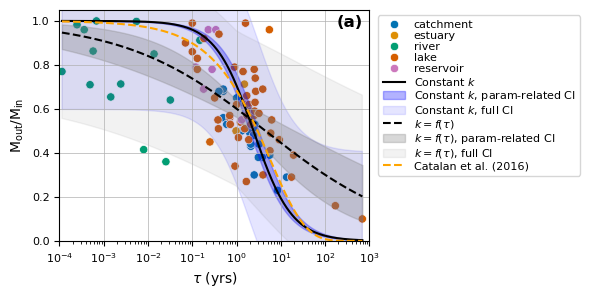

In [12]:
# Plot all models on one plot

fig, ax = plt.subplots(figsize=(4, 3))

# Plot observations
sns.scatterplot(data=df, x='tau', y='mo_mi', hue='Type', palette='colorblind') 

# # Plot each model's fit
# tau_values = np.linspace(df['tau'].min(), df['tau'].max(), 100000)
tau_values = np.logspace(np.log10(df['tau'].min()), np.log10(df['tau'].max()), 1000)

ax.plot(tau_values, voll_fit1.eval(tau=tau_values), label=r'Constant $k$', color='k')

# Confidence intervals on Vollenweider with constant sigma
plt.fill_between(tau_values, pred_voll1_lower_params, pred_voll1_upper_params, color='blue', alpha=0.3, label=r'Constant $k$, param-related CI')
plt.fill_between(tau_values, pred_voll1_lower_full, pred_voll1_upper_full, color='blue', alpha=0.1, label=r'Constant $k$, full CI')

# ax.plot(tau_values, exp_fit1.eval(tau=tau_values), label='Exponential (constant $k$)', color='red')

ax.plot(tau_values, voll_fit2.eval(tau=tau_values), ls='--', label=r'$k = f(\tau$)', color='k')

# ax.plot(tau_values, exp_fit2.eval(tau=tau_values), ls='--', label=r'Exponential ($k = f(\tau$))', color='red')

# Confidence intervals on the Vollenweider with time-varying sigma
plt.fill_between(tau_values, pred_voll2_lower_params, pred_voll2_upper_params, color='gray', alpha=0.3, label=r'$k = f(\tau$), param-related CI')
plt.fill_between(tau_values, pred_voll2_lower_full, pred_voll2_upper_full, color='gray', alpha=0.1, label=r'$k = f(\tau$), full CI')

# Also plot implied results of Catalan's regression, when rearranged for Cout/Cin
trans_catalan = np.exp(-0.38 * tau_values ** 0.55)  # Double checked & ok
ax.plot(tau_values, trans_catalan, ls='--', label="Catalan et al. (2016)", color='orange')

plt.ylim(0, 1.05)
plt.xlim(0.0001, 1000)
# plt.xlim(0, 0.2)
plt.xscale('log')

plt.grid(True, which='major', linewidth=0.5)

# Add labels and legend
plt.ylabel('$\mathrm{M_{out}/M_{in}}$', size=10)
plt.xlabel((r'$\tau$ (yrs)'), size=10)
plt.tick_params(axis='both', which='major', labelsize=8)
plt.tick_params(axis='both', which='minor', labelsize=8)
ax.legend(fontsize=8, bbox_to_anchor=(1.01, 1), labelspacing=0.1)

# Add the plot location label in bold text to the top right corner
plt.text(0.98, 0.98, '(a)', transform=plt.gca().transAxes, fontsize=12, fontweight='bold', ha='right', va='top')

plt.savefig(r'graphs/trans-vs-tau_all-data.png', bbox_inches='tight')

# Show plot
plt.show()

# Comments

* Huge scatter in our transmission estimates, which is what models actually care about getting right (I think?)
* Slightly higher error in the stream data than in the other waterbody types. MAE of 0.14 instead of 0.12 (or 0.09 for "catchments").
* Slightly lower error when fitting to this "clean" dataset without bioassay data than when validating C2016's regression result against it (MAEs of 0.14 and 0.15 for estuaries and lakes, instead of 0.12; 0.17 for rivers instead of 0.14)
* Parameter-related error is generally smaller than residual error, sometimes a lot smaller.

# Compare bioassay and field data

In [63]:
# Average over sample duplicates (different treatments) in the bioassay data
id_cols = ['Site', 'Type']
data_cols = ['tau', 'mo_mi']
bioassay_nodups_df = bioassay_df[id_cols+data_cols].groupby(id_cols).mean().reset_index()
bioassay_nodups_df.rename({'mo_mi': 'T_assay'}, axis=1, inplace=True)
bioassay_nodups_df

,Site,Type,tau,T_assay
0,Fraser,Lake,0.076712,0.555534
1,Attavarasjön,Lake,0.017808,0.912687
2,Bajit,Lake,0.219178,0.931745
3,Batorino,Lake,0.054795,0.843795
4,Bowker,Lake,0.076712,0.199673
...,...,...,...,...
118,York_estuary9salinity,Estuary,0.013699,0.953369
119,À la truite,Lake,0.038356,0.910842
120,Öralven,Estuary,0.034247,0.928303
121,Öralven,River,0.034247,0.932403


In [67]:
# Drop any field data with t > the largest t in the bioassay data or < the smallest
overlap_field_df = df.loc[df['tau'] < bioassay_nodups_df['tau'].max()*1.1, :]
overlap_field_df = overlap_field_df.loc[overlap_field_df['tau'] > bioassay_nodups_df['tau'].min()/1.1, :]
overlap_field_df.rename({'mo_mi': 'T_field'}, axis=1, inplace=True)

overlap_field_df.describe()

,tau,T_field
count,71.000000,71.000000
mean,1.332687,0.627928
std,1.082025,0.181196
min,0.005479,0.270000
25%,0.360000,0.510000
50%,1.220000,0.620000
75%,2.100000,0.755000
max,3.950000,0.997600


In [68]:
join_df = pd.merge(bioassay_nodups_df, overlap_field_df, on='tau', how='outer', suffixes=('_bio', '_field'))
join_df

,Site_bio,Type_bio,tau,T_assay,Site_field,Type_field,T_field
0,Bran de Scie (9/1),Lake,0.00274,0.991485,NaN,NaN,NaN
1,Bran de Scie (9/22),Lake,0.00274,0.996390,NaN,NaN,NaN
2,Browker (9/15),Lake,0.00274,0.990307,NaN,NaN,NaN
3,Des Monts (9/8),Lake,0.00274,0.994204,NaN,NaN,NaN
4,Fraser (9/22),Lake,0.00274,0.992668,NaN,NaN,NaN
...,...,...,...,...,...,...,...
187,Williams,Lake,3.75000,0.005173,NaN,NaN,NaN
188,NaN,NaN,3.80000,NaN,16,catchment,0.38
189,NaN,NaN,3.90000,NaN,Lake 227,lake,0.69
190,NaN,NaN,3.95000,NaN,Plastic,lake,0.30


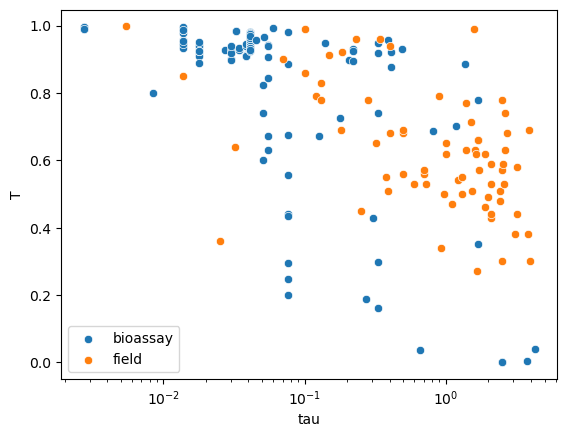

In [69]:
ax = sns.scatterplot(data=join_df, x='tau', y='T_assay', label='bioassay')
sns.scatterplot(data=join_df, x='tau', y='T_field', label='field')
plt.xscale('log')
plt.ylabel('T')
plt.show()